In [1]:
%matplotlib inline
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import *
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)

### Pre-processing

In [2]:
#Setting some inital parameters
height, width = 224, 224
batch_size=64

In [3]:
data_dir = 'brain_tumor_dataset' #change_path

def image_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255., 
            validation_split=0.2,
            )
    train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=batch_size,
            subset="training",
            #color_mode = 'grayscale',
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    val_ds = datagen.flow_from_directory(
              data_dir,
              subset="validation",
              #seed=123,
              #color_mode = 'grayscale',
              class_mode='binary',
              target_size=(height, width),
              batch_size=batch_size,
            classes={'no': 0., 'yes': 1.}
            )
    return train_ds, val_ds

train_ds, val_ds = image_generator(height,width)

total_image = np.concatenate([train_ds.labels,val_ds.labels])
print('\n\n',{'No_brain_tumor_cases':len(np.where(total_image==0)[0]),
      'brain_tumor_cases':len(np.where(total_image==1)[0])})

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


 {'No_brain_tumor_cases': 98, 'brain_tumor_cases': 155}


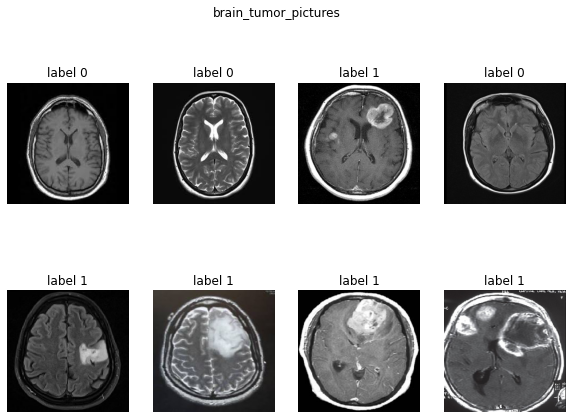

In [4]:
fig, ax = plt.subplots(2, 4, figsize=(10, 7))
fig.suptitle("brain_tumor_pictures")
for k in range(8):
    images, labels = train_ds.next()
    i, j = k//4, k%4
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f'label {int(labels[0])}')
    ax[i, j].axis('off')
plt.show()

### Initial VGG16 Model

In [5]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg16 = tf.keras.Sequential()
model_vgg16.add(base_model)
model_vgg16.add(tf.keras.layers.Flatten())

model_vgg16.add(tf.keras.layers.Dropout(0.2)) #add

model_vgg16.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_vgg16.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['acc'])
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [6]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_vgg16.fit(
        train_ds,
        validation_data=val_ds,
        epochs=15, 
        shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/15
4/4 [==============================] - ETA: 0s - loss: 10.0182 - acc: 0.4384
Epoch 1: acc improved from -inf to 0.43842, saving model to model\vgg16_best.h5
4/4 [==============================] - 31s 8s/step - loss: 10.0182 - acc: 0.4384 - val_loss: 9.3913 - val_acc: 0.6200
Epoch 2/15
4/4 [==============================] - ETA: 0s - loss: 7.8383 - acc: 0.6207
Epoch 2: acc improved from 0.43842 to 0.62069, saving model to model\vgg16_best.h5
4/4 [==============================] - 33s 11s/step - loss: 7.8383 - acc: 0.6207 - val_loss: 2.1754 - val_acc: 0.7600
Epoch 3/15
4/4 [==============================] - ETA: 0s - loss: 3.0474 - acc: 0.6158
Epoch 3: acc did not improve from 0.62069
4/4 [==============================] - 33s 11s/step - loss: 3.0474 - acc: 0.6158 - val_loss: 2.6203 - val_acc: 0.7000
Epoch 4/15
4/4 [==============================] - ETA: 0s - loss: 1.4182 - acc: 0.8079
Epoch 4: acc improved from 0.62069 to 0.80788, saving model to model\vgg16_best.h5
4/4 [====

### Evaluation of Initial Model

In [7]:
train_result = model_vgg16.evaluate(train_ds)
val_result = model_vgg16.evaluate(val_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

1/1 [==============================] - 7s 7s/step - loss: 0.9425 - acc: 0.8400


,Train,Val
Loss,0.005404,0.942517
Acc,1.000000,0.840000


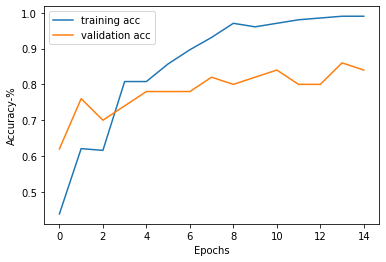

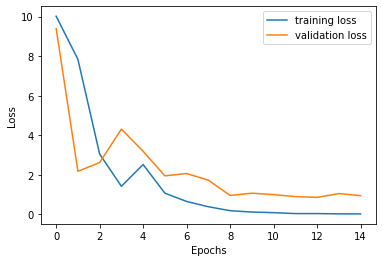

In [8]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

### Adding Image Augmentation

In [9]:
def augmentation_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            rotation_range=30,
            horizontal_flip=True,
            brightness_range=(0.5, 1.0)
            )
    aug_train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=64,
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    return aug_train_ds
aug_train_ds = augmentation_generator(height,width)

Found 253 images belonging to 2 classes.


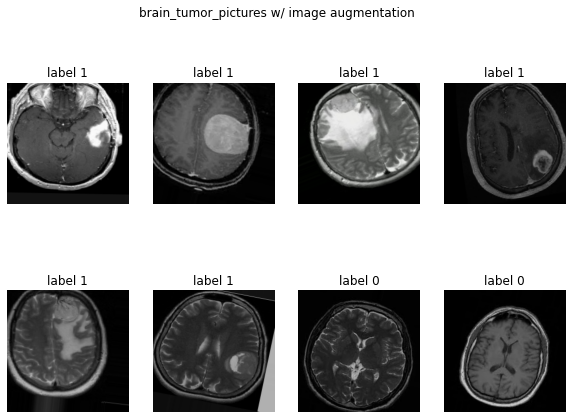

In [10]:
fig, ax = plt.subplots(2, 4, figsize=(10, 7))
fig.suptitle("brain_tumor_pictures w/ image augmentation")
for k in range(8):
    images, labels = aug_train_ds.next()
    i, j = k//4, k%4
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f'label {int(labels[0])}')
    ax[i, j].axis('off')
plt.show()

### Improved VGG16 Model

In [11]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,
                              patience=2, min_lr=0.0000001)
callbacks_list = [checkpoint,reduce_lr]

history = model_vgg16.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=15, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 0.6163 - acc: 0.8340
Epoch 1: acc did not improve from 0.99015
4/4 [==============================] - 41s 11s/step - loss: 0.6163 - acc: 0.8340 - val_loss: 0.8456 - val_acc: 0.8800 - lr: 0.0100
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 0.4210 - acc: 0.8735
Epoch 2: acc did not improve from 0.99015
4/4 [==============================] - 41s 11s/step - loss: 0.4210 - acc: 0.8735 - val_loss: 0.6477 - val_acc: 0.9000 - lr: 0.0100
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 0.2812 - acc: 0.8972
Epoch 3: acc did not improve from 0.99015
4/4 [==============================] - 41s 11s/step - loss: 0.2812 - acc: 0.8972 - val_loss: 0.4892 - val_acc: 0.9200 - lr: 0.0100
Epoch 4/20
4/4 [==============================] - ETA: 0s - loss: 0.3349 - acc: 0.8814
Epoch 4: acc did not improve from 0.99015
4/4 [==============================] - 41s 11s/step - loss: 0.3349 - acc: 0.8814 - val_loss

### Evaluation of Improved Model

In [12]:
train_result = model_vgg16.evaluate(train_ds)
val_result = model_vgg16.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

1/1 [==============================] - 7s 7s/step - loss: 0.0841 - acc: 0.9600


,Train,Val
Loss,0.003715,0.084081
Acc,1.000000,0.960000


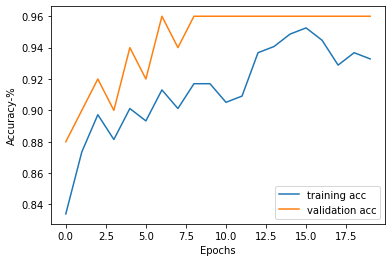

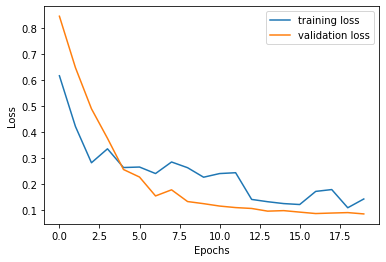

In [13]:
plot_learning_curve(history)

In [15]:
ypred_val = model_vgg16.predict(val_ds[0][0])
ypred_val = np.array([1 if x > 0.5 else 0 for x in ypred_val])
y_val = val_ds[0][-1]

print('\n',confusion_matrix(y_val, ypred_val))
print('\n',classification_report(ypred_val,y_val))

2/2 [==============================] - 5s 2s/step

 [[18  1]
 [ 1 30]]

               precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.97      0.97      0.97        31

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50

